# Import modules

In [1]:
from utils import * 

import numpy as np
import pandas as pd
from pprint import pprint
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Gensim
from gensim.test.utils import datapath
from gensim.test.utils import common_texts, get_tmpfile

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.option_context('display.max_colwidth', 500);

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


config = get_config('config.yaml')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enlik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\enlik\Miniconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# Import dataset
df = pd.read_csv(config['csv_input_local']['bolt_apple_google_p2'], index_col=0)
df = df.reset_index(drop=True)
reviews = df.review
reviews

0        Your drivers are great BUT your support is no ...
1        Loving the app, but can only give it a medium ...
2        The response time with regards to customer ser...
3        This has been happening for some time now and ...
4        The drivers almost always never have change an...
                               ...                        
17925                                           Great app!
17926                                          Great app!!
17927    The drivers regularly get the wrong address du...
17928                                        Just love it!
17929                                           Great app!
Name: review, Length: 17930, dtype: object

In [3]:
# setup input and output path
input_path = 'preprocessed_data/bolt/p2/'

term_doc = pd.read_pickle(input_path + 'term_doc.pkl')
data_lemmatized = pd.read_pickle(input_path + 'data_lemmatized.pkl')
dictionary = pd.read_pickle(input_path + 'dictionary.pkl')
tf_idf = pd.read_pickle(input_path + 'tf_idf.pkl')

In [4]:
len(data_lemmatized)

17930

# <mark>Mallet's LDA model after tuning &#8592; Best Model
*The difference between Mallet and Gensim’s standard LDA is that Gensim uses a Variational Bayes sampling method which is faster but less precise that Mallet’s Gibbs Sampling.*  [link](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)

In [5]:
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath("model"))
# ldamallet

In [6]:
%%time
# Solution on windows 10, fixing Java path on mallet.bat
# https://stackoverflow.com/questions/52845345/lda-mallet-calledprocesserror
# mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

# mallet_path = 'mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat'

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
#                                              corpus = term_doc,
#                                              num_topics = 6, 
#                                              random_seed = 100,
#                                              id2word = dictionary,
#                                              alpha = 1.5)

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=term_doc, num_topics=20, id2word=dictionary)

Wall time: 50.9 s


In [7]:
# ldamallet.save(datapath("model"))
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath("model"))

In [8]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(3,
  [('guy', 0.15099135739705136),
   ('people', 0.11438739196746314),
   ('request', 0.0971021860701576),
   ('call', 0.06558210472801221),
   ('client', 0.05083884087442806),
   ('message', 0.027452974072191154),
   ('contact', 0.02491103202846975),
   ('review', 0.02389425521098119),
   ('answer', 0.01677681748856126),
   ('ride', 0.01626842907981698)]),
 (12,
  [('car', 0.3474663908996898),
   ('driver', 0.2673216132368149),
   ('vehicle', 0.040847983453981385),
   ('country', 0.01964839710444674),
   ('attitude', 0.013960703205791106),
   ('condition', 0.013960703205791106),
   ('idea', 0.012409513960703205),
   ('delivery', 0.011375387797311272),
   ('choice', 0.008790072388831437),
   ('house', 0.0077559462254395035)]),
 (4,
  [('time', 0.17889908256880735),
   ('minute', 0.14067278287461774),
   ('driver', 0.1218144750254842),
   ('today', 0.05504587155963303),
   ('show', 0.03618756371049949),
   ('distance', 0.03109072375127421),
   ('arrival', 0.02803261977573904),
   ('m

## Comparison of Coherence Score between LDA Standard and LDA Mallet

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=term_doc,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [10]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(term_doc))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.139674052171797

Coherence Score:  0.41386208758923626


## Visualize Mallet's LDA model

In [11]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, term_doc, dictionary)
vis

C:\Users\enlik\Miniconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.111250 -0.088612       1        1  5.189084
13     0.077079 -0.002340       2        1  5.117788
0      0.170893  0.002205       3        1  5.104809
3     -0.132970 -0.062718       4        1  5.070937
10    -0.223194  0.250052       5        1  5.040504
17    -0.141081 -0.274498       6        1  5.029457
11    -0.176006  0.151613       7        1  5.022682
19     0.295336  0.050008       8        1  5.011162
15     0.233553  0.015966       9        1  5.010704
12     0.251509  0.026899      10        1  5.001949
8     -0.169965  0.159550      11        1  5.000667
4      0.156320 -0.017885      12        1  4.995408
1      0.283876  0.033373      13        1  4.995294
2     -0.119664 -0.091788      14        1  4.990956
14    -0.228064  0.275739      15        1  4.988812
16     0.259324  0.048014      16        1  4.973193
18    -0.065921 -0.030250      17        1  4.941241
6     -0.106920 -0.069650      18        1  4.939684
9     -0.143571 -0.277219      19        1  4.873040
5     -0.109285 -0.098458      20        1  4.702628, topic_info=        Term         Freq        Total Category  logprob  loglift
5     driver  4166.000000  4166.000000  Default  30.0000  30.0000
32       app  1903.000000  1903.000000  Default  29.0000  29.0000
123     love  1170.000000  1170.000000  Default  28.0000  28.0000
50   service  1294.000000  1294.000000  Default  27.0000  27.0000
16      ride  1112.000000  1112.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
829     pass     5.087820    11.329399  Topic20  -5.9322   2.2565
17      rude     6.105384    32.667301  Topic20  -5.7499   1.3798
39      time     5.087820  1213.354301  Topic20  -5.9322  -2.4172
90       lot     5.087820   140.479244  Topic20  -5.9322  -0.2612
130    block     5.087820    31.037327  Topic20  -5.9322   1.2487

[1205 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
1036     18  0.957416                abit
555       4  0.951007            able_get
2090     16  0.964275            able_use
1690      1  0.990776  absolutely_useless
726      19  0.945354               abuja
...     ...       ...                 ...
151       3  0.077712           yesterday
151      10  0.019428           yesterday
151      14  0.893691           yesterday
743      17  0.955129                zone
603      10  0.947949                zoom

[1518 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 1, 4, 11, 18, 12, 20, 16, 13, 9, 5, 2, 3, 15, 17, 19, 7, 10, 6])

In [12]:
pyLDAvis.save_html(vis, 'mallet_lda_vis/bolt/p3/mallet_lda_topics=20.html')

In [13]:
coherence_model_m = CoherenceModel(model=model, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
coherence_model_m.get_coherence_per_topic()

[-0.19846318297464605,
 -0.2752786068164499,
 -0.38454758940586553,
 -0.2108354979160239,
 -0.2640396062392157,
 -0.48213302466880703,
 -0.32751742782822885,
 -0.04966236715710106,
 -0.2629899927955844,
 -0.4362614991912683,
 -0.2208630793739565,
 -0.23816818677344134,
 -0.3290120443741511,
 -0.1561567059339015,
 -0.39066065700897346,
 -0.23704093169543994,
 -0.29023789263256733,
 -0.337125163728536,
 -0.34473910173613265,
 -0.3703231719885671]

In [14]:
# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
model.top_topics(corpus = term_doc,topn=10)

[([(0.09489747257987602, 'card'),
   (0.06962327134000953, 'support'),
   (0.06676204101096805, 'response'),
   (0.06580829756795423, 'account'),
   (0.06056270863137816, 'number'),
   (0.04816404387219838, 'payment'),
   (0.047687172150691466, 'email'),
   (0.036242250834525515, 'month'),
   (0.036242250834525515, 'day'),
   (0.03385789222699094, 'week')],
  -3.0621293431960397),
 ([(0.1461959224266534, 'customer'),
   (0.1009448035803083, 'money'),
   (0.0835405271009448, 'fare'),
   (0.07160616608652412, 'route'),
   (0.07011437095972153, 'pay'),
   (0.057682744903033316, 'driver'),
   (0.055196419691695676, 'traffic'),
   (0.05171556439582297, 'scam'),
   (0.030830432620586774, 'road'),
   (0.02138239681750373, 'min')],
  -3.3865274481869463),
 ([(0.15099135739705136, 'guy'),
   (0.11438739196746314, 'people'),
   (0.0971021860701576, 'request'),
   (0.06558210472801221, 'call'),
   (0.05083884087442806, 'client'),
   (0.027452974072191154, 'message'),
   (0.02491103202846975, 'con

### For each topic, we could look at frequent and relevant words

In [15]:
frequencies = ldamallet.word_topics.sum(axis=0)
p_word = frequencies / ldamallet.word_topics.sum()
p_word_given_topic = ldamallet.word_topics / np.sum(ldamallet.word_topics, axis = 0)

lamda = 0.5
relevance = lamda * p_word_given_topic + (1-lamda) * p_word_given_topic / p_word 

C:\Users\enlik\AppData\Local\Temp/ipykernel_14300/1698140663.py:3: RuntimeWarning: invalid value encountered in true_divide
  p_word_given_topic = ldamallet.word_topics / np.sum(ldamallet.word_topics, axis = 0)


In [16]:
np.argsort(relevance[0,])[::-1][:15]

array([1738, 1615,  330, 1044,  914, 3282, 1489,  314, 1132,  918, 1878,
       2003,  180, 2552,  995], dtype=int64)

In [17]:
dictionary[1826]

'calibrate'

In [18]:
topic_dict = {0.: "Platform/Device", 1.: "User Experience", 2.: "Value", 3.: "Service", 4.: "Trouble-shooting", 5.:"Shows"}

for topic_id in range(6):
    words = []
    for id in np.argsort(relevance[topic_id,])[::-1][:15]:
        words.append(dictionary[id])
    print(f"Topic: {topic_dict[topic_id]}")
    print(words)
    print('\n')

Topic: Platform/Device
['ok', 'furthermore', 'up', 'know', 'keep', 'thanx', 'well', 'self', 'go', 'mean', 'going', 'everything', 'd', 'th', 'course']


Topic: User Experience
['look', 'well', 'course', 'asking', 'get', 'away', 'mean', 'up', 'being', 'third', 'etc', 'keep', 'going', 'cause', 'aside']


Topic: Value
['name', 'away', 'noone', 'overall', 'down', 'do', 'saying', 'need', 'plus', 'help', 'know', 'using', 'cause', 'seeing', 'going']


Topic: Service
['away', 'let', 'try', 'know', 'think', 'whole', 'need', 'tell', 'saying', 'want', 'as', 'cause', 'look', 'do', 'com']


Topic: Trouble-shooting
['saying', 'welcome', 'up', 'know', 'away', 'thanx', 'com', 'asking', 'wish', 'aside', 'self', 'well', 'going', 'course', 'cause']


Topic: Shows
['believe', 'overall', 'let', 'example', 'th', 'right', 'everything', 'go', 'aside', 'wish', 'contain', 'well', 'self', 'com', 'thanx']




## <mark>Mallet Model - Interpret the model</mark>

In [19]:
# ldamallet = gensim.models.wrappers.LdaMallet.load(datapath('model'))
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [20]:
df_topic_sents_keywords_m = format_topics_sentences(model, term_doc, data_lemmatized, df)

Getting main topic for document...
0  1000  2000  3000  4000  5000  6000  7000  8000  9000  10000  11000  12000  13000  14000  15000  16000  17000  

In [21]:
all_topics = model.get_document_topics(bow = term_doc)

In [22]:
# df_topic_sents_keywords_m[df_topic_sents_keywords_m[0]]
df_topic_sents_keywords_m

,Dominant_Topic,Perc_Contribution,Keywords,0
0,7.0,0.1459,"card, support, response, account, number, paym...","[driver, support, computer, response, case, re..."
1,2.0,0.1063,"ride, rate, rider, rating, yesterday, leave, n...","[rating, moment, driver, rating, trip, driver,..."
2,0.0,0.1436,"driver, phone, company, promo, drive, friend, ...","[response, thank, reimbursement, part, custome..."
3,6.0,0.0919,"price, application, amount, friendly_driver, e...","[time, show, estimate, amount, destination, lo..."
4,18.0,0.0645,"time, experience, drivers_alway, job, scooter,...","[driver, option, change, time, transfer, trust..."
...,...,...,...,...
17925,0.0,0.0500,"driver, phone, company, promo, drive, friend, ...",[]
17926,0.0,0.0500,"driver, phone, company, promo, drive, friend, ...",[]
17927,13.0,0.0872,"customer, money, fare, route, pay, driver, tra...","[driver, wrong_address, auto, replacement, hot..."
17928,5.0,0.0686,"love, code, nice_one, easy_use, really_enjoy, ...",[love]


In [23]:
# save to pickle file - df_topic_sents_keywords_m
import pickle

output_path = 'lda_mallet_model/'
with open(output_path + 'mallet_lda_df_bolt_p3.pkl', 'wb') as f:
    pickle.dump(df_topic_sents_keywords_m, f)


### Mallet LDA - Finding the dominant topic in each document

In [38]:
df_dominant_topic_m = find_dominant_topic_in_each_doc(df_topic_sents_keywords_m, df)
print("Finding the dominant topic in each document")
df_dominant_topic_m.head(10).style.set_properties(subset=['review'], **{'width': '400px'})

Finding the dominant topic in each document


,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
0,7.000000,0.145900,"card, support, response, account, number, payment, email, month, day, week","['driver', 'support', 'computer', 'response', 'case', 'response', 'star', 'support', 'discount', 'account', 'month', 'thought', 'client']",3,"Your drivers are great BUT your support is no good. Why can't it be like Uber where you can actually speak to someone. Instead of getting computer generated responses or like in my case, no response at all. The three stars are for the support. Also I have received a single discount to this account since I installed it three months ago. I'm very disappointed in Bolt, I thought they were there for their clients."
1,2.000000,0.106300,"ride, rate, rider, rating, yesterday, leave, nonsense, refuse, rain, function","['rating', 'moment', 'driver', 'rating', 'trip', 'driver', 'apartment', 'ride', 'review', 'drive_destination', 'rude']",3,"Loving the app, but can only give it a medium rating at the moment as the drivers you give a bad rating on still gets your trip. I had a bad experience with a driver outside my apartment, but he always gets my rides as he's parked there when with my one star and bad review (refused to drive to the destination, rude and aggressive)."
2,0.000000,0.143600,"driver, phone, company, promo, drive, friend, day, report, part, home","['response', 'thank', 'reimbursement', 'part', 'customer', 'promo', 'part', 'situation', 'part', 'company', 'extra_money', 'people', 'card', 'dodgy', 'stick', 'amount', 'card']",4,The response time with regards to customer service was great and thank you. Kindly improve on the reimbursement part because it's not every customer who'll appreciate a promo. That part put some of us in a very sticky situation financially especially now that we have COVID-19. The last part would be for your company not to always take extra money just because people are paying with cards. That's dodgy. Stick to the same amount whether I'm paying cash or with a card.
3,6.000000,0.091900,"price, application, amount, friendly_driver, estimate, hour, end, load, surge, difference","['time', 'show', 'estimate', 'amount', 'destination', 'location', 'price', 'way', 'uninstall', 'rubbish', 'app']",1,This has been happening for some time now and i always keep quiet. You will show me an estimate of the amount for the destination and when i get to my location the price i will see will be way higher than what you showed. I will stop using you. Just decided to give this feedback before i uninstall this rubbish app
4,18.000000,0.064500,"time, experience, drivers_alway, job, scooter, year, driving, day, family, alot","['driver', 'option', 'change', 'time', 'transfer', 'trust', 'card', 'cash', 'please_fix', 'problem', 'way']",3,"The drivers almost always never have change and I'm left with no option but to leave my 100-300 naira change with them which I obviously don't intend to. It's not all the time we're able to transfer and not everyone trust using their cards with the app, for those of us that use cash please fix this problem whatever way, it's really annoying."
5,15.000000,0.084900,"driver, problem, thing, place, lot, time, life, area, network, person","['driver', 'driver', 'thing', 'customer', 'year', 'service', 'cause', 'thing']",1,I requested a ride and the driver (Akhona) completed the trip without picking me up. Money was deducted from my bank account and I have reported this 2 days ago and nothing has been resolved. The driver is driving around freely and probably doing the same thing to other customers. I've been using Bolt for more than 4 years now and must say I'm shocked at the customer support service. I've since stopped using bolt cause I'm afraid the same thing will happen again. Very very disappointed.
6,7.000000,0.085400,"card, support, response, account, number, payment, email, month, day, week","['month', 'unknown_error', 'message', 'driver', 'cancel', 'place', 'lift', 'fix', 'app', 'tomorrow']",3,Idk 

In [39]:
df_dominant_topic_m

,Dominant_Topic,Perc_Contribution,Keywords,Text,rating,review
0,7.0,0.1459,"card, support, response, account, number, paym...","[driver, support, computer, response, case, re...",3,Your drivers are great BUT your support is no ...
1,2.0,0.1063,"ride, rate, rider, rating, yesterday, leave, n...","[rating, moment, driver, rating, trip, driver,...",3,"Loving the app, but can only give it a medium ..."
2,0.0,0.1436,"driver, phone, company, promo, drive, friend, ...","[response, thank, reimbursement, part, custome...",4,The response time with regards to customer ser...
3,6.0,0.0919,"price, application, amount, friendly_driver, e...","[time, show, estimate, amount, destination, lo...",1,This has been happening for some time now and ...
4,18.0,0.0645,"time, experience, drivers_alway, job, scooter,...","[driver, option, change, time, transfer, trust...",3,The drivers almost always never have change an...
...,...,...,...,...,...,...
17925,0.0,0.0500,"driver, phone, company, promo, drive, friend, ...",[],5,Great app!
17926,0.0,0.0500,"driver, phone, company, promo, drive, friend, ...",[],5,Great app!!
17927,13.0,0.0872,"customer, money, fare, route, pay, driver, tra...","[driver, wrong_address, auto, replacement, hot...",1,The drivers regularly get the wrong address du...
17928,5.0,0.0686,"love, code, nice_one, easy_use, really_enjoy, ...",[love],5,Just love it!


### Get Average Ratings

In [40]:
# get list of unique values sorted - https://www.geeksforgeeks.org/python-get-unique-values-list/
list_unique_topics = np.unique(df_dominant_topic_m['Dominant_Topic'])

for topic in list_unique_topics:
    avg_rating = round(df_dominant_topic_m[df_dominant_topic_m['Dominant_Topic'] == topic]['rating'].mean(), 2)
    print('Average Rating for Topic ' + str(topic) + ' = ' + str(avg_rating))

Average Rating for Topic 0.0 = 4.56
Average Rating for Topic 1.0 = 3.37
Average Rating for Topic 2.0 = 3.91
Average Rating for Topic 3.0 = 3.24
Average Rating for Topic 4.0 = 3.15
Average Rating for Topic 5.0 = 4.78
Average Rating for Topic 6.0 = 3.84
Average Rating for Topic 7.0 = 2.25
Average Rating for Topic 8.0 = 3.59
Average Rating for Topic 9.0 = 4.36
Average Rating for Topic 10.0 = 3.43
Average Rating for Topic 11.0 = 3.26
Average Rating for Topic 12.0 = 3.7
Average Rating for Topic 13.0 = 2.78
Average Rating for Topic 14.0 = 3.81
Average Rating for Topic 15.0 = 3.47
Average Rating for Topic 16.0 = 3.47
Average Rating for Topic 17.0 = 3.26
Average Rating for Topic 18.0 = 4.1
Average Rating for Topic 19.0 = 4.08


### Get Average Sentiments

In [145]:
df_sentiment = pd.read_csv(config['csv_input_local']['bolt_apple_google_p1_topic_sentiment'], index_col=0)
df_sentiment = df_sentiment[['rating','review','sentiment_score']]
# df_sentiment = df_sentiment.head(200) # testing purpose
df_sentiment

,rating,review,sentiment_score
0,1,The first thing I noticed is that you can't pr...,-1
1,4,Your GPS setting around Cape Town Internationa...,0
2,1,I was invited by my friend and was given a £10...,-1
3,3,Your drivers are great BUT your support is no ...,0
4,3,"Loving the app, but can only give it a medium ...",1
...,...,...,...
40360,1,"Its the 5th time Im saying, But When Will ther...",0
40361,5,Just love it!,3
40362,5,Great app!,3
40363,5,Super convenient and fast!,1


In [146]:
df_topic_p2 = df_dominant_topic_m[['Dominant_Topic','rating','review']]
# df_topic_p2 = df_topic_p2.head(200) #testing purpose
df_topic_p2

,Dominant_Topic,rating,review
0,7.0,3,Your drivers are great BUT your support is no ...
1,2.0,3,"Loving the app, but can only give it a medium ..."
2,0.0,4,The response time with regards to customer ser...
3,6.0,1,This has been happening for some time now and ...
4,18.0,3,The drivers almost always never have change an...
...,...,...,...
17925,0.0,5,Great app!
17926,0.0,5,Great app!!
17927,13.0,1,The drivers regularly get the wrong address du...
17928,5.0,5,Just love it!


In [148]:
%%time
list_of_sentiment_scores_p2 = []

for i in range(0, len(df_topic_p2)):
    for j in range(0, len(df_sentiment)):
        if df_topic_p2['review'][i] == df_sentiment['review'][j]:
            sentiment_score = df_sentiment['sentiment_score'][j]
#             print(df_sentiment['review'][j])
#             print(df_sentiment['sentiment_score'][j])
#             print('\n')
            break
    
    if sentiment_score is None:
        sentiment_score = 0
        
    list_of_sentiment_scores_p2.append(sentiment_score)

Wall time: 1h 6min 38s


In [149]:
# list_of_sentiment_scores_p2

In [150]:
df_topic_p2['sentiment_score'] = list_of_sentiment_scores_p2
df_topic_p2

C:\Users\enlik\Miniconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Dominant_Topic,rating,review,sentiment_score
0,7.0,3,Your drivers are great BUT your support is no ...,0
1,2.0,3,"Loving the app, but can only give it a medium ...",1
2,0.0,4,The response time with regards to customer ser...,2
3,6.0,1,This has been happening for some time now and ...,-2
4,18.0,3,The drivers almost always never have change an...,0
...,...,...,...,...
17925,0.0,5,Great app!,3
17926,0.0,5,Great app!!,3
17927,13.0,1,The drivers regularly get the wrong address du...,-2
17928,5.0,5,Just love it!,3


In [151]:
for topic in list_unique_topics:
    avg_sentiment = round(df_topic_p2[df_topic_p2['Dominant_Topic'] == topic]['sentiment_score'].mean(),2)
    print('Average Sentiment for Topic ' + str(topic) + ' = ' + str(avg_sentiment))

Average Sentiment for Topic 0.0 = 1.78
Average Sentiment for Topic 1.0 = 0.4
Average Sentiment for Topic 2.0 = 1.04
Average Sentiment for Topic 3.0 = 0.25
Average Sentiment for Topic 4.0 = 0.16
Average Sentiment for Topic 5.0 = 1.98
Average Sentiment for Topic 6.0 = 0.97
Average Sentiment for Topic 7.0 = -0.88
Average Sentiment for Topic 8.0 = 0.7
Average Sentiment for Topic 9.0 = 1.6
Average Sentiment for Topic 10.0 = 0.51
Average Sentiment for Topic 11.0 = 0.26
Average Sentiment for Topic 12.0 = 0.82
Average Sentiment for Topic 13.0 = -0.3
Average Sentiment for Topic 14.0 = 0.98
Average Sentiment for Topic 15.0 = 0.54
Average Sentiment for Topic 16.0 = 0.57
Average Sentiment for Topic 17.0 = 0.29
Average Sentiment for Topic 18.0 = 1.25
Average Sentiment for Topic 19.0 = 1.24


In [152]:
df_topic_p2.to_csv('../review_mining/csv_output/1_bolt/bolt_apple_google_p2_sentiment.csv')

### Mallet LDA - Find the most representative document for each topic

In [26]:
print("Find the most representative document for each topic")
sent_topics_sorteddf_m = find_most_representative_doc_for_each_doc(df_topic_sents_keywords_m, df)
sent_topics_sorteddf_m.style.set_properties(subset=['review'], **{'width': '400px'})

Find the most representative document for each topic


,Dominant_Topic,Perc_Contribution,Topic_Keywords,star_rating,review
0,0.000000,0.156600,"driver, phone, company, promo, drive, friend, day, report, part, home",1,They are the most worse company. Disgusting drivers and disgusting costumer service. First time I used Bolt the fair came in a lot higher then the highest expected price didn’t think much of it just thought because of traffic etc. Second time I kept watch on the drivers satnav and right Infront of my eyes saw him ignore the satnav and purposely took a longer route. Now be it was about 10pm over the Christmas period I had all three of my children with me and didn’t want to say anything with the plan to get into contact with the costumer service team. On making the phone call and explaining the situation it came back that he did indeed ignore the route the Bolt satnav had told him to take so in other words to get more money from me he went the longer route. Disgusting human! Costumer service gave me a £5 good will gesture as well as the £5 in the extra fair cost. So again it came to me having to arrange a traci for my brother his wife and children to get home. I ordered the cab with using the £5 voucher looked up the fastest route from mine to my brothers and proceeded to track the journey via the app. And guess what? Guy did the exact same thing. Instead of doing a straight right down the middle route he went up and away from my address around and back down. Google’s maps that night gave me the quickest route and it should of only been a 35/40 mins journey which turned into a 1 hour and 25 min journey so you can imagine the fair price. I was absolutely livid. I screen recorded me going from my google search which showed the direct route then into the app and recorded the whole journey. Next day I again called costumer service after submitting a formal complaint through the app with the screen recording and screen shots of the driver fair that was expected and the fair it ended up to be. Again they made me right in what I was saying but refused to refund the money into my bank account on the basis it would be unfair on the driver. Instead offered me a voucher with money of my next few journeys. That voucher added up to £20 from the added extra fair! I pointed out why in the hell am I going to accept that when the money is going straight back into your sick and disgusting company. Your company is a disgrace and your drivers are equally that to. Unsafe drivers with green cards. How can you employ people who are so sly and devious! Costumer service made me right but would not accept any wrong doing. How can that be. STAY WELL AWAY FROM THIS COMPANY. I almost certain TFL will be getting reports from young women/men of being taken over safety issues. Mark my words
1,1.000000,0.134600,"driver, journey, cost, safety, night, hate, competitor, check, problem, music",1,"Twice now I have requested a ride from bolt and the drivers have accepted the ride and started the journey without picking me up at my pick up location. The drivers change the drop off location, either having picked up someone else or because they don’t want to complete the journey. I’m really appalled at the level of help the customer service provide. I contacted the help point to which their solution for the problem was for me to contact the driver myself. They were unable to help cancel the journey on their end and therefore I was charged a fee for a ride I did not complete. This took days to discuss a possible refund as bolt would only issue me discount codes (much lower than the sum of both journeys I once again did not take). Appalled and not happy with this service at all."
2,2.000000,0.155200,"ride, rate, rider, rating, yesterday, leave, nonsense, refuse, rain, function",1,"Bolt is the worst app to work with compared to Uber, you embark on a card trip and at the end of day your account is blocked and deactivated and no reason is given to you. You carry a rider and he/she refuse to pay you at the end of the

### Mallet LDA - Topic distribution across documents

In [27]:
# Show
print("Topic distribution across documents")
df_dominant_topic_m = topic_distribution_across_docs(df_topic_sents_keywords_m)
df_dominant_topic_m.style.set_properties(subset=['Keywords'], **{'width': '400px'})

Topic distribution across documents


,Dominant_Topic,Keywords,Num_Documents,Perc_Documents
0,0.000000,"driver, phone, company, promo, drive, friend, day, report, part, home",6972,0.388800
1,1.000000,"driver, journey, cost, safety, night, hate, competitor, check, problem, music",1282,0.071500
2,2.000000,"ride, rate, rider, rating, yesterday, leave, nonsense, refuse, rain, function",804,0.044800
3,3.000000,"guy, people, request, call, client, message, contact, review, answer, ride",760,0.042400
4,4.000000,"time, minute, driver, today, show, distance, arrival, morning, timing, amazing_service",759,0.042300
5,5.000000,"love, code, nice_one, easy_use, really_enjoy, always_pleasure, start, stuff, navigate, kind",647,0.036100
6,6.000000,"price, application, amount, friendly_driver, estimate, hour, end, load, surge, difference",600,0.033500
7,7.000000,"card, support, response, account, number, payment, email, month, day, week",561,0.031300
8,8.000000,"work, taxi, map, app, system, user, pricing, business, city, order",541,0.030200
9,9.000000,"service, discount, promotion, quality, good_service, excellent, standard, thumb, level, food",541,0.030200


In [28]:
coherence_model = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
coherence_model.get_coherence_per_topic()

[-0.19846318297464605,
 -0.2752786068164499,
 -0.38454758940586553,
 -0.2108354979160239,
 -0.2640396062392157,
 -0.48213302466880703,
 -0.32751742782822885,
 -0.04966236715710106,
 -0.2629899927955844,
 -0.4362614991912683,
 -0.2208630793739565,
 -0.23816818677344134,
 -0.3290120443741511,
 -0.1561567059339015,
 -0.39066065700897346,
 -0.23704093169543994,
 -0.29023789263256733,
 -0.337125163728536,
 -0.34473910173613265,
 -0.3703231719885671]

# Find Optimal Number of Topics

In [29]:
# Solution on windows 10, fixing Java path on mallet.bat
# https://stackoverflow.com/questions/52845345/lda-mallet-calledprocesserror
# mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})

# mallet_path = 'mallet-2.0.8/bin/mallet.bat' # update this path
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat'

# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=term_doc, num_topics=5, id2word=dictionary)

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [31]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=term_doc, texts=data_lemmatized, start=2, limit=40, step=6)


Wall time: 6min 52s


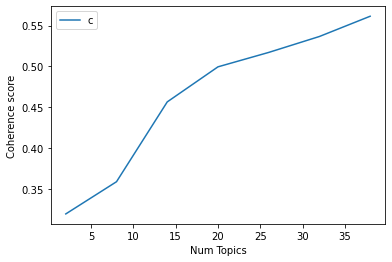

In [32]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.3193
Num Topics = 8  has Coherence Value of 0.3587
Num Topics = 14  has Coherence Value of 0.4565
Num Topics = 20  has Coherence Value of 0.4994
Num Topics = 26  has Coherence Value of 0.5171
Num Topics = 32  has Coherence Value of 0.5366
Num Topics = 38  has Coherence Value of 0.5614


In [34]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.615*"love" + 0.058*"friendly_driver" + 0.041*"drivers_alway" + '
  '0.019*"good_service" + 0.018*"fast_efficient" + 0.014*"driving" + '
  '0.012*"delivery" + 0.011*"alternative" + 0.008*"hand" + 0.007*"connection"'),
 (1,
  '0.406*"price" + 0.105*"rate" + 0.066*"promo" + 0.063*"promotion" + '
  '0.057*"change" + 0.043*"star" + 0.027*"notification" + 0.012*"increase" + '
  '0.012*"surge" + 0.007*"stick"'),
 (2,
  '0.249*"service" + 0.102*"taxi" + 0.046*"lot" + 0.043*"area" + 0.032*"cost" '
  '+ 0.030*"transportation" + 0.028*"city" + 0.027*"feature" + 0.024*"road" + '
  '0.023*"bit"'),
 (3,
  '0.318*"trip" + 0.209*"driver" + 0.079*"rider" + 0.033*"rating" + '
  '0.030*"drivers_alway" + 0.017*"rude" + 0.013*"moment" + 0.013*"history" + '
  '0.010*"cancellation" + 0.009*"text"'),
 (4,
  '0.343*"car" + 0.095*"driver" + 0.095*"request" + 0.023*"person" + '
  '0.022*"quality" + 0.016*"type" + 0.015*"comfort" + 0.014*"condition" + '
  '0.014*"talk" + 0.013*"attitude"'),
 (5,
  '0.09